# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [17]:
#installation of libraries and packages if needed
%pip install imageio
%pip install scikit-image
%pip install matplotlib
%pip install tensorflow
%pip install keras #high level API for tensorflow
%pip install pandas
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [30]:
#Importing libraries

import numpy as np
import os

import random as rn

import imageio
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import cv2
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [31]:
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [32]:
print(tf.__version__)
print(keras.__version__)

2.13.0
2.13.1


In [33]:
np.random.seed(30)
rn.seed(30)
seed = tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [34]:
from pathlib import Path
import numpy as np

#Andrea's patè
#model = Path('/Users/andreaarosio/OneDrive - Politecnico di Milano/POLI/2 anno/1 semestre/Creative Programming/HACKATON/Codici interessanti/Rete neurale per movimenti/DS1_FIST')

#Filippo's patè
model = Path('/Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Creative Programming and Computing ⌨️/HACKATON/Codici interessanti/Rete neurale per movimenti/DS1_FIST')

train_doc = np.random.permutation((model / 'train/train.csv').read_text().splitlines())
val_doc = np.random.permutation((model / 'valid/val.csv').read_text().splitlines())

batch_size = 32 #experiment with the batch size. Volendo si può alzare o abbassare
num_classes = 2 #gesti da riconoscere


print(f'Train length: {len(train_doc)}')
print(f'Validation length: {len(val_doc)}')

Train length: 3442
Validation length: 216


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [35]:
def preprocess_image(image, channel, height, width):
    image = resize_image(image, height, width)
    return normalise_image(image, channel)

In [36]:
def normalise_image(image, channel):
    return (image[...,channel])/255

In [37]:
def resize_image(image, height, width):
    h, w, c = image.shape
    return resize(image, (height, width), anti_aliasing=True)

In [38]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 120, 120, 3]

In [39]:
def generate_common(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, height=120, width=120, augment=False):
    ''' 
    parameters:
        t: train_doc or val_doc (type of data)
        source_path: path of the images
        batch_size: batch size
        img_idx: list of frames to be considered
        batch: batch number
        batch_data: numpy array to store the data (output)
        batch_labels: numpy array to store the labels (output)
        height: height of the image
        width: width of the image
        augment: boolean to augment the images
    '''

    

    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            

            # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
            if augment:
                image = resize_image(image, height, width)
                if np.random.randn() > 0:
                    image = datagen.random_transform(image) #random transformation of the image to augment the dataset dimension                   

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            
            batch_data[folder,idx,:,:,0] = preprocess_image(image, 0, height, width) #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = preprocess_image(image, 1, height, width) #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = preprocess_image(image, 2, height, width) #normalise and feed in the image                  
            
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [40]:
# # Kept default height and width to 120x120
# def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
#     #print( 'Source path = ', source_path, '; batch size =', batch_size)
#     total_frames = 30

#     while True:
#         t = np.random.permutation(folder_list) #randomly shuffle the list of all videos
#         num_batches = len(t)//batch_size # calculate the number of batches
#         img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

#         for batch in range(num_batches): # we iterate over the number of batches
#             batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
#             batch_labels = np.zeros((batch_size, 5)) #batch_labels is the one hot representation of the output       

#             yield generate_common(t, source_path, batch_size, img_idx, batch, batch_data, batch_labels, height, width) 
        
#         # write the code for the remaining data points which are left after full batches
#         if (len(t)%batch_size):
#             remaining_batch_size = len(t)%batch_size
#             batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
#             batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

#             yield generate_common(t, source_path, remaining_batch_size, img_idx, num_batches, batch_data, batch_labels, height, width)



def extract_common_name(filename):
    """Estrae la parte del nome file che inizia da 'jpg'."""
    parts = filename.split("_jpg")  # Divide il nome sul primo '_jpg'
    if len(parts) > 1:
        return "jpg" + parts[1]  # Ricostruisce la parte comune mantenendo 'jpg'
    return filename  # In caso di errore, ritorna il nome originale

def load_labels(csv_path):
    """Carica il file CSV e crea un dizionario {parte_comune: label_index}."""
    df = pd.read_csv(csv_path)
    label_map = {"open": 0, "fist": 1}  # Mappatura delle classi
    
    labels_dict = {}
    for _, row in df.iterrows():
        common_name = extract_common_name(row["filename"])  # Normalizza il nome
        labels_dict[common_name] = label_map[row["class"]]  # Assegna la classe
    
    return labels_dict


def generate(source_path, csv_path, batch_size, height=120, width=120, augment=False):
    labels_dict = load_labels(csv_path)
    image_list = os.listdir(source_path)
    valid_images = [img for img in image_list if extract_common_name(img) in labels_dict]

    while True:
        np.random.shuffle(valid_images)
        num_batches = len(valid_images) // batch_size

        for batch in range(num_batches + 1):
            start = batch * batch_size
            end = min((batch + 1) * batch_size, len(valid_images))
            batch_files = valid_images[start:end]

            batch_data = np.zeros((len(batch_files), height, width, 3))  # 3 canali per RGB
            batch_labels = np.zeros((len(batch_files), 2))  # 2 classi

            for i, file in enumerate(batch_files):
                img = cv2.imread(os.path.join(source_path, file))
                img = cv2.resize(img, (width, height))
                batch_data[i] = img / 255.0  # Normalizza i pixel

                common_name = extract_common_name(file)
                label = labels_dict[common_name]
                batch_labels[i] = to_categorical(label, num_classes=2)

            yield batch_data, batch_labels

In [41]:
curr_dt_time = datetime.datetime.now()
train_path = str(model / "train")
val_path = str(model/ "valid")

train_doc = str(model / "train" / "train.csv")
val_doc = str(model / "valid" / "val.csv")

batch_size = 32

train_gen = generate(train_path, train_doc, batch_size)
val_gen = generate(val_path, val_doc, batch_size)


num_train_sequences = len(train_doc)

print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs, the order of the sum
print ('# epochs =', num_epochs)

# training sequences = 189
# validation sequences = 187
# epochs = 20


#### Validating the Generator

In [42]:
# check complete batch shape
sample_generator = generate(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generate(val_path, val_doc, batch_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

(32, 120, 120, 3)
(32, 120, 120, 3)


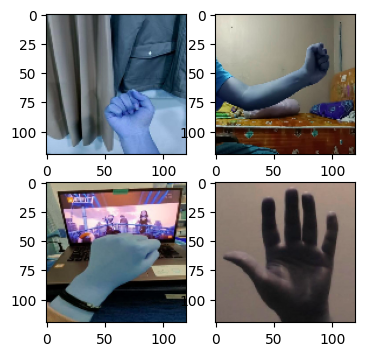

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))

ax[0,0].imshow(sample_batch_data[17])  # Seleziona immagine 16
ax[0,1].imshow(sample_batch_data[22])  # Seleziona immagine 25

ax[1,0].imshow(sample_val_batch_data[11])  # Seleziona immagine 16 dal validation set
ax[1,1].imshow(sample_val_batch_data[21])  # Seleziona immagine 25 dal validation set

plt.show()


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [44]:
from keras.models import Sequential, Model
from keras.layers import  Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
#from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

Model callback utility

In [45]:
def plot_loss_accuracy(history):
    print("Chiavi disponibili in history:", history.history.keys())  # DEBUG

    # Controllo se usare accuracy o categorical_accuracy
    accuracy_key = 'accuracy' if 'accuracy' in history.history else 'categorical_accuracy'
    val_accuracy_key = 'val_' + accuracy_key

    # Plot accuracy
    plt.plot(history.history[accuracy_key])
    plt.plot(history.history[val_accuracy_key])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


In [46]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) 

    return [checkpoint, LR]


In [47]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [48]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

#### Model 1: 
Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [49]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 60  #experiment with the batch size
print ('# batch size =', batch_size)

model = conv3D()

print (model.summary())

# epochs = 20
# batch size = 60
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_6 (Bat  (None, 20, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 10, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [50]:
callbacks_list = model_callbacks("model_30_conv3D_1")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size)
val_generator   = generate(val_path, val_doc, batch_size)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

# Modifica da Conv3D a Conv2D
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Due classi (open e fist)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [40]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=num_epochs,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks_list)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 6.8218 - accuracy: 0.5417
Epoch 1: saving model to model_30_conv3D_1_2025-03-29_18-26-42/model-00001-6.82184-0.54167-2.01152-0.75598.h5
4/4 [==============================] - 1s 276ms/step - loss: 6.8218 - accuracy: 0.5417 - val_loss: 2.0115 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 4.7058 - accuracy: 0.4208
Epoch 2: saving model to model_30_conv3D_1_2025-03-29_18-26-42/model-00002-4.70576-0.42083-0.81154-0.53110.h5
4/4 [==============================] - 1s 177ms/step - loss: 4.7058 - accuracy: 0.4208 - val_loss: 0.8115 - val_accuracy: 0.5311 - lr: 0.0010
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 2.1681 - accuracy: 0.5000
Epoch 3: saving model to model_30_conv3D_1_2025-03-29_18-26-42/model-00003-2.16807-0.50000-0.50517-0.73684.h5
4/4 [==============================] - 1s 173ms/step - loss: 2.1681 - accuracy: 0.5000 - val_loss: 0.5052 - va

Chiavi disponibili in history: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


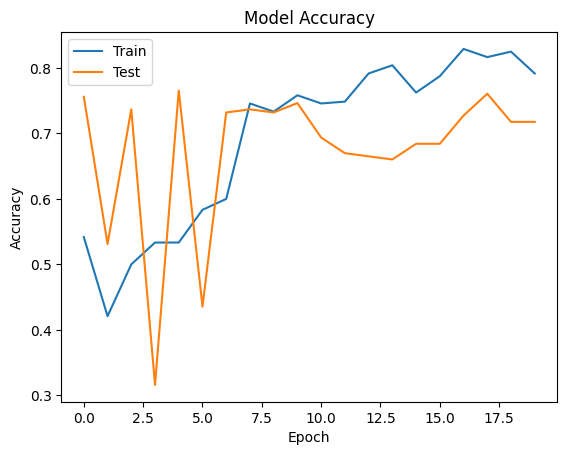

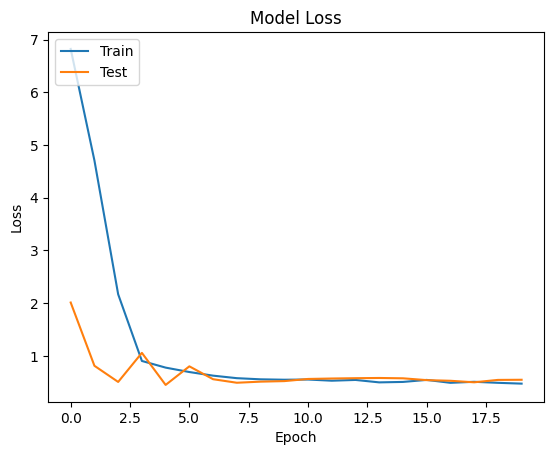

In [41]:
plot_loss_accuracy(history)

#### Model 2: 
Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)¶

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Creazione del modello
model = Sequential()

# Primo layer Conv2D
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(120, 120, 3)))  # Primo layer con 16 filtri
model.add(MaxPooling2D((2, 2)))  # MaxPooling per ridurre le dimensioni

# Secondo layer Conv2D
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Terzo layer Conv2D
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Quarto layer Conv2D
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten per passare ai layer densi
model.add(Flatten())

# Primo layer denso
model.add(Dense(256, activation='relu'))

# Secondo layer denso
model.add(Dense(128, activation='relu'))

# Layer di output con 2 classi (fist e open)
model.add(Dense(2, activation='softmax'))

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Riepilogo del modello
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 59, 59, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 64)       

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [43]:
# Calcolo dei passi per epoca e di validazione
steps_per_epoch = len(train_doc) // batch_size
validation_steps = len(val_doc) // batch_size

# Definizione dei generatori
train_generator = generate(train_path, train_doc, batch_size)  # usa una sola immagine per batch
val_generator = generate(val_path, val_doc, batch_size)  # usa una sola immagine per batch

# Lista di callback
callbacks_list = model_callbacks("model_Conv2D_2")  


In [44]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch,  # Numero di passi per epoca per il training
    epochs=num_epochs, 
    verbose=1,        
    callbacks=callbacks_list, 
    validation_data=val_generator,  
    validation_steps=validation_steps,  # Numero di passi per epoca per la validazione
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.4833
Epoch 1: saving model to model_Conv2D_2_2025-03-29_18-26-55/model-00001-0.71303-0.48333-0.99645-0.26111.h5
3/3 [==============================] - 1s 270ms/step - loss: 0.7130 - accuracy: 0.4833 - val_loss: 0.9965 - val_accuracy: 0.2611 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.4444
Epoch 2: saving model to model_Conv2D_2_2025-03-29_18-26-55/model-00002-0.74754-0.44444-0.69758-0.31667.h5
3/3 [==============================] - 0s 200ms/step - loss: 0.7475 - accuracy: 0.4444 - val_loss: 0.6976 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5944
Epoch 3: saving model to model_Conv2D_2_2025-03-29_18-26-55/model-00003-0.69120-0.59444-0.69429-0.37222.h5
3/3 [==============================] - 1s 229ms/step - loss: 0.6912 - accuracy: 0.5944 - val_loss: 0.6943 - val_accurac

Chiavi disponibili in history: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


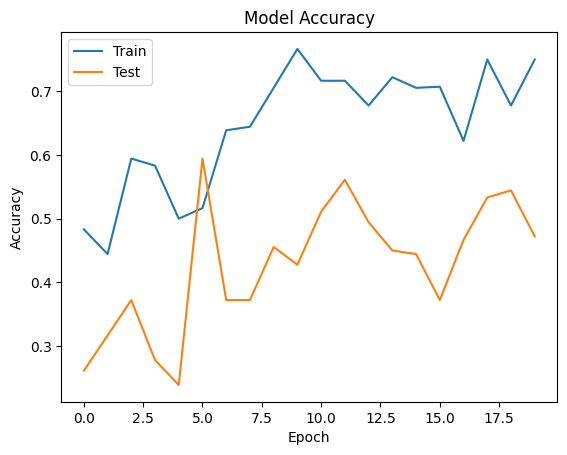

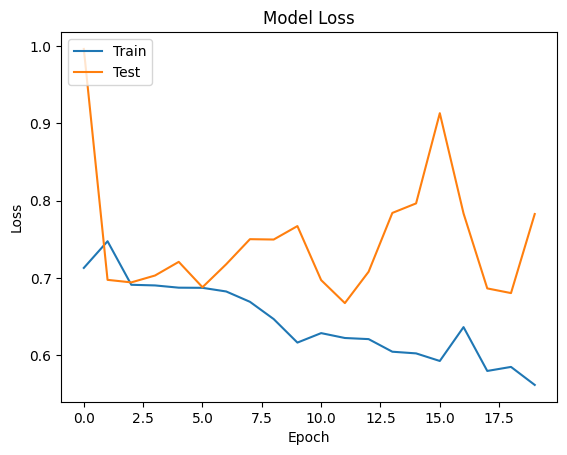

In [45]:
plot_loss_accuracy(history)

#### Model 3: 
Conv 2D Model with (32, 64, 128, 256) filters conv 2D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Creazione del modello
model = Sequential()

# Primo layer Conv2D
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))  # Primo layer con 16 filtri
model.add(MaxPooling2D((2, 2)))  # MaxPooling per ridurre le dimensioni

# Secondo layer Conv2D
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Terzo layer Conv2D
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Quarto layer Conv2D
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten per passare ai layer densi
model.add(Flatten())

# Primo layer denso
model.add(Dense(128, activation='relu'))

# Secondo layer denso
model.add(Dense(128, activation='relu'))

# Layer di output con 2 classi (fist e open)
model.add(Dense(2, activation='softmax'))

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Riepilogo del modello
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 59, 59, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 13, 13, 128)      

In [47]:
# Calcolo dei passi per epoca e di validazione
steps_per_epoch = len(train_doc) // batch_size
validation_steps = len(val_doc) // batch_size

# Definizione dei generatori
train_generator = generate(train_path, train_doc, batch_size)  # usa una sola immagine per batch
val_generator = generate(val_path, val_doc, batch_size)  # usa una sola immagine per batch

# Lista di callback
callbacks_list = model_callbacks("model_Conv2D_2")  # Puoi cambiarlo con un nome diverso per il tuo modello


In [48]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch,  # Numero di passi per epoca per il training
    epochs=num_epochs, 
    verbose=1,        
    callbacks=callbacks_list, 
    validation_data=val_generator,  
    validation_steps=validation_steps,  # Numero di passi per epoca per la validazione
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 0.7227 - accuracy: 0.4444
Epoch 1: saving model to model_Conv2D_2_2025-03-29_18-27-06/model-00001-0.72273-0.44444-0.75968-0.26111.h5
3/3 [==============================] - 1s 428ms/step - loss: 0.7227 - accuracy: 0.4444 - val_loss: 0.7597 - val_accuracy: 0.2611 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.4944
Epoch 2: saving model to model_Conv2D_2_2025-03-29_18-27-06/model-00002-0.69871-0.49444-0.71202-0.24161.h5
3/3 [==============================] - 1s 378ms/step - loss: 0.6987 - accuracy: 0.4944 - val_loss: 0.7120 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.5444
Epoch 3: saving model to model_Conv2D_2_2025-03-29_18-27-06/model-00003-0.69490-0.54444-0.68413-0.76510.h5
3/3 [==============================] - 1s 348ms/step - loss: 0.6949 - accuracy: 0.5444 - val_loss: 0.6841 - val_accurac

Chiavi disponibili in history: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


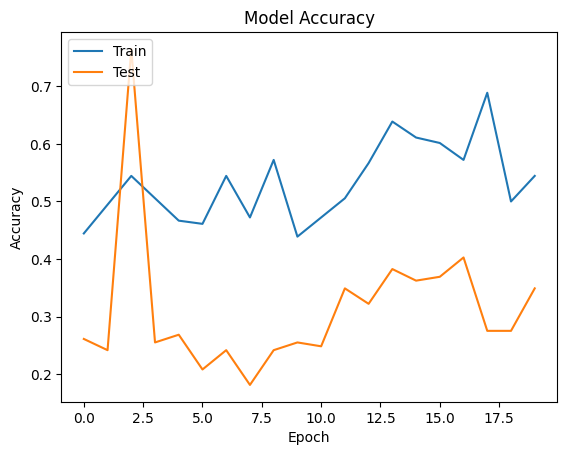

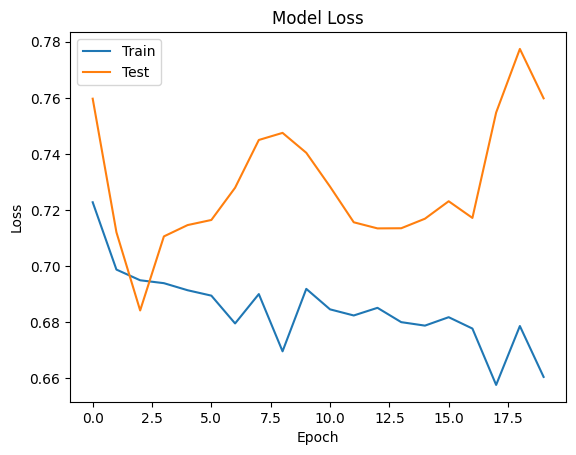

In [49]:
plot_loss_accuracy(history)

#### Model 4: 
Conv 2D Model with (32, 64, 128, 256) filters conv 2D layers + 128 dense layer + 128 dense layer + image size 120 by 120) with batch normalization

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau # Per ridurre il learning rate

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 118, 118, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 59, 59, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 57, 57, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 57, 57, 64)        256       
 chNormalization)                                                
                                                      

In [51]:
# Calcolo dei passi per epoca e di validazione
steps_per_epoch = len(train_doc) // batch_size
validation_steps = len(val_doc) // batch_size

# Definizione dei generatori
train_generator = generate(train_path, train_doc, batch_size)  # usa una sola immagine per batch
val_generator = generate(val_path, val_doc, batch_size)  # usa una sola immagine per batch

# Lista di callback
callbacks_list = model_callbacks("model_Conv2D_2")  # Puoi cambiarlo con un nome diverso per il tuo modello

In [52]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch,  # Numero di passi per epoca per il training
    epochs=40, 
    verbose=1,        
    callbacks=[callbacks_list, reduce_lr], 
    validation_data=val_generator,  
    validation_steps=validation_steps,  # Numero di passi per epoca per la validazione
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 1.6529 - accuracy: 0.5667
Epoch 1: saving model to model_Conv2D_2_2025-03-29_18-27-24/model-00001-1.65290-0.56667-0.74712-0.20000.h5
3/3 [==============================] - 2s 510ms/step - loss: 1.6529 - accuracy: 0.5667 - val_loss: 0.7471 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/40
3/3 [==============================] - ETA: 0s - loss: 1.1684 - accuracy: 0.6389
Epoch 2: saving model to model_Conv2D_2_2025-03-29_18-27-24/model-00002-1.16839-0.63889-0.83765-0.16779.h5
3/3 [==============================] - 1s 425ms/step - loss: 1.1684 - accuracy: 0.6389 - val_loss: 0.8376 - val_accuracy: 0.1678 - lr: 0.0010
Epoch 3/40
3/3 [==============================] - ETA: 0s - loss: 0.8890 - accuracy: 0.6889
Epoch 3: saving model to model_Conv2D_2_2025-03-29_18-27-24/model-00003-0.88896-0.68889-0.90144-0.16779.h5
3/3 [==============================] - 1s 403ms/step - loss: 0.8890 - accuracy: 0.6889 - val_loss: 0.9014 - val_accurac

Chiavi disponibili in history: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


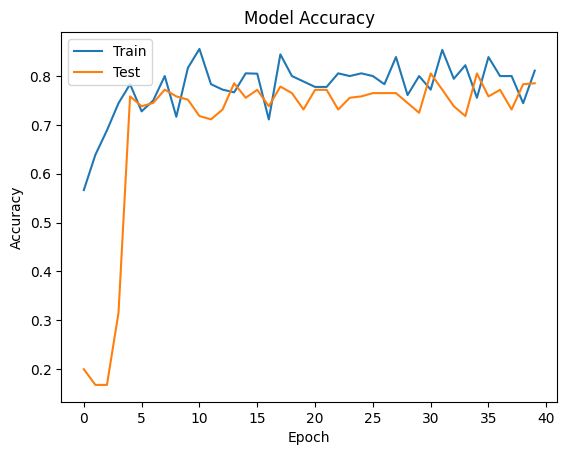

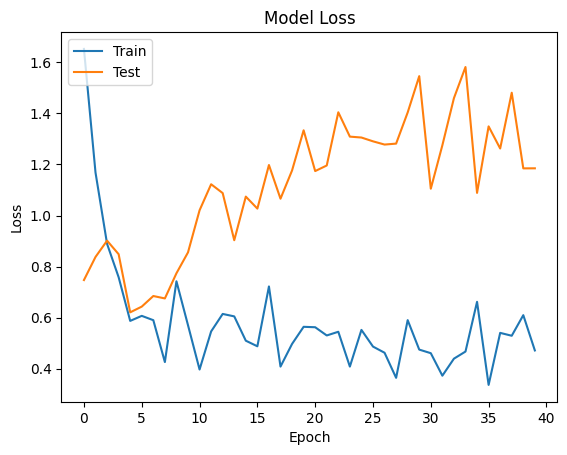

In [53]:
plot_loss_accuracy(history)


### TRANSFER LEARNING - MobileNet + DENSE

In [52]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def hand_segmentation_preprocessing(image):
    """Preprocessing per isolare la mano dallo sfondo"""
    # 1. Converti in HSV per segmentazione colore
    hsv = tf.image.rgb_to_hsv(image)
    
    # 2. Filtra per tonalità della pelle (regola questi valori)
    lower_skin = tf.constant([0.0, 0.2, 0.0], dtype=tf.float32)
    upper_skin = tf.constant([0.1, 1.0, 1.0], dtype=tf.float32)
    mask = tf.logical_and(
        tf.greater(hsv, lower_skin),
        tf.less(hsv, upper_skin))
    mask = tf.cast(mask, tf.float32)
    
    # 3. Applica la maschera e normalizza
    masked_image = image * mask
    normalized = masked_image / 255.0  # Normalizza a [0,1]
    
    return normalized

def robust_mobilenetv2_hand_classifier(input_shape=(120, 120, 3), num_classes=2):
    # Input layer con preprocessing
    inputs = Input(shape=input_shape)
    
    # Preprocessing personalizzato (solo durante il training)
    if tf.keras.backend.learning_phase():
        x = tf.keras.layers.Lambda(hand_segmentation_preprocessing)(inputs)
    else:
        x = inputs / 255.0  # Solo normalizzazione durante l'inferenza
    
    # Aggiungi augmentations per robustezza alla luce
    if tf.keras.backend.learning_phase():
        x = tf.keras.layers.RandomBrightness(0.3)(x)
        x = tf.keras.layers.RandomContrast(0.3)(x)
    
    # Base model
    base_model = MobileNetV2(
        input_tensor=x,
        weights='imagenet',
        include_top=False,
        alpha=0.35  # Versione più leggera (1.0 è la default)
    )
    
    # Fine-tuning configurabile
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Top model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Model compilation
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

#### Model 5: 
Mobilenet + DENSE

In [53]:
#model = mobilenet_classifier(fine_tune=True)

print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 59, 59, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 111392)            0         
                                                                 
 dense_8 (Dense)             (None, 64)                7129152   
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 7130178 (27.20 MB)
Trainable params: 7130178 (27.20 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [54]:
callbacks_list = model_callbacks("model_mobilenet_dense")

steps_per_epoch, validation_steps = calculate_steps(len(train_doc), len(val_doc), batch_size)


train_generator = generate(train_path, train_doc, batch_size)
val_generator   = generate(val_path, val_doc, batch_size)

In [55]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1,  # ⚠️ Ridotto a 1 perché i generatori non supportano multiprocessing
    use_multiprocessing=False,  # Disattivato multiprocessing
    initial_epoch=0
)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 6.8218 - accuracy: 0.5417
Epoch 1: saving model to model_mobilenet_dense_2025-03-29_18-59-39/model-00001-6.82184-0.54167-2.01152-0.75598.h5
4/4 [==============================] - 1s 249ms/step - loss: 6.8218 - accuracy: 0.5417 - val_loss: 2.0115 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 4.7058 - accuracy: 0.4208
Epoch 2: saving model to model_mobilenet_dense_2025-03-29_18-59-39/model-00002-4.70576-0.42083-0.81154-0.53110.h5
4/4 [==============================] - 1s 169ms/step - loss: 4.7058 - accuracy: 0.4208 - val_loss: 0.8115 - val_accuracy: 0.5311 - lr: 0.0010
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 2.1681 - accuracy: 0.5000
Epoch 3: saving model to model_mobilenet_dense_2025-03-29_18-59-39/model-00003-2.16807-0.50000-0.50517-0.73684.h5
4/4 [==============================] - 1s 168ms/step - loss: 2.1681 - accuracy: 0.5000 - val_loss:

Chiavi disponibili in history: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


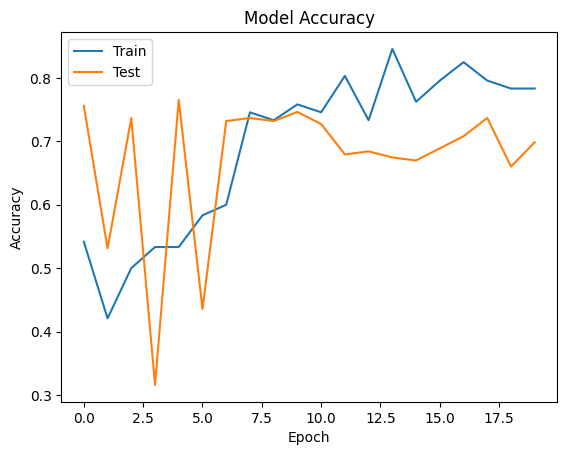

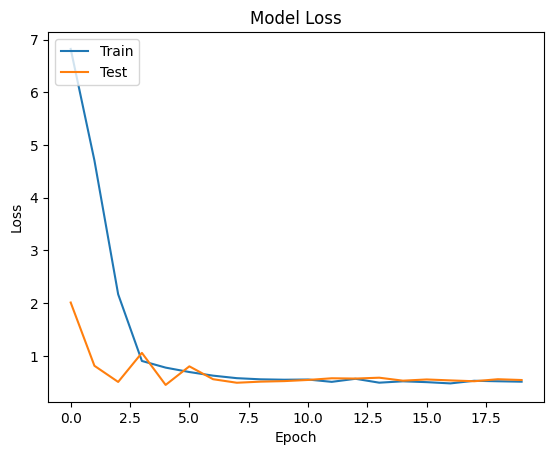

In [56]:
plot_loss_accuracy(history)

#### Model 6: 
Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [59]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D


def mobilenet_dense_variant(input_shape=(120, 120, 3), fine_tune=False, dense_nodes=128, dropout=0.3, num_classes=2):
    # Carica MobileNet senza il top (strati densi finali)
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Se non vogliamo fare fine-tuning, blocchiamo i pesi
    if not fine_tune:
        for layer in base_model.layers:
            layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Sostituisce Flatten per ridurre i parametri
        Dense(256, activation='relu'),
        Dropout(dropout),
        Dense(dense_nodes, activation='relu'),
        Dropout(dropout),
        Dense(num_classes, activation='softmax')  # Output finale
    ])

    # Compilazione del modello
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [60]:
callbacks_list = model_callbacks("model_30_retrain_mobilenet_dense_variant")

steps_per_epoch, validation_steps = calculate_steps(len(train_doc), len(val_doc), batch_size)


train_generator = generate(train_path, train_doc, batch_size)
val_generator   = generate(val_path, val_doc, batch_size)

In [61]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1,  # ⚠️ Ridotto a 1 perché i generatori non supportano multiprocessing
    use_multiprocessing=False,  # Disattivato multiprocessing
    initial_epoch=0
)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.6236 - accuracy: 0.7417
Epoch 1: saving model to model_30_retrain_mobilenet_dense_variant_2025-03-29_18-28-37/model-00001-0.62357-0.74167-1.06477-0.75598.h5
4/4 [==============================] - 2s 441ms/step - loss: 0.6236 - accuracy: 0.7417 - val_loss: 1.0648 - val_accuracy: 0.7560 - lr: 2.4414e-08
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.7667
Epoch 2: saving model to model_30_retrain_mobilenet_dense_variant_2025-03-29_18-28-37/model-00002-0.51677-0.76667-1.16826-0.73684.h5
4/4 [==============================] - 1s 365ms/step - loss: 0.5168 - accuracy: 0.7667 - val_loss: 1.1683 - val_accuracy: 0.7368 - lr: 2.4414e-08
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.8125
Epoch 3: saving model to model_30_retrain_mobilenet_dense_variant_2025-03-29_18-28-37/model-00003-0.49963-0.81250-1.01762-0.75598.h5
4/4 [============================

Chiavi disponibili in history: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


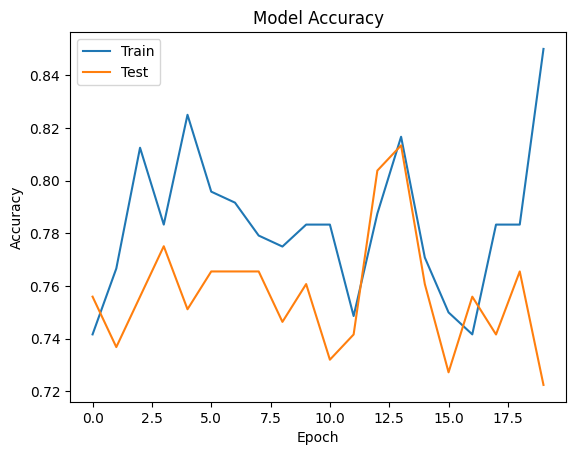

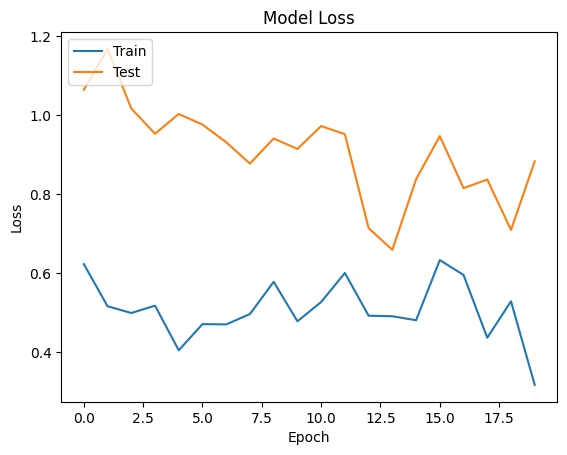

In [62]:
plot_loss_accuracy(history)

### Load Selected Model
Loading the selected model from the disk 

In [64]:
# model-00016-0.03003-0.99548-0.05517-0.98000.h5

from keras.models import load_model
#model = load_model('model-00016-0.03003-0.99548-0.05517-0.98000.h5')
#model.summary()